In [1]:
import numpy as np
import math as m
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import odeint
import scipy.io
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.stats import invgamma  

# Problem 2

In [2]:
def Model(IC,t,paras):
    
    
    try:
        d1 = paras['d1'].value
        k2 = paras['k2'].value
        delta = paras['delta'].value
        bE = paras['bE'].value
    except KeyError:
        d1, k2,delta,bE = paras
        
        
    # Constants
    lambda1 = 1E4
    lambda2 = 31.98
    c       = 13
    deltaE  = 0.1
    d2      = 0.01
    m1      = 1E-5
    rho1    = 1
    Kb      = 100
    eps     = 0
    f       = 0.34
    m2      = 1E-5
    rho2    = 1
    dE      = 0.25
    k1      = 8E-7
    k2      = 1E-4
    Nt      = 100
    lambdaE = 1
    Kd      = 500
    
    # Declare initial conditions
    T1      = IC[0]
    T2      = IC[1]
    T1_star = IC[2]
    T2_star = IC[3]
    V       = IC[4]
    E       = IC[5]
    
    # Declare parameters
    #d1    = paras[0]
    #k2    = paras[1]
    #delta = paras[2]
    #bE    = paras[3]
    
    # Define ode
    dT1      = lambda1-d1*T1-(1-eps)*k1*V*T1
    dT2      = lambda2-d2*T2-(1-f*eps)*k2*V*T2
    dT1_star = (1-eps)*k1*V*T1-delta*T1_star-m1*E*T1_star
    dT2_star = (1-f*eps)*k2*V*T2-delta*T2_star-m2*E*T2_star
    dV       = Nt*delta*(T1_star+T2_star)-c*V-((1-eps)*rho1*k1*T1+(1-f*eps)*rho2*k2*T2)*V
    dE       = lambdaE+(bE*(T1_star+T2_star)*E)/(T1_star+T2_star+Kb)-(dE*(T1_star+T2_star)*E)/(T1_star+T2_star+Kd)-deltaE*E
    return(dT1,dT2,dT1_star,dT2_star,dV,dE)    


def g(t, x0, paras):
    x = odeint(Model, x0, t, args=(paras,))
    return x

def residual(paras, t, data):
    x0  = paras['T1'].value, paras['T2'].value, paras['T1_star'].value, paras['T2_star'].value, paras['V'].value, paras['E'].value
    mod = g(t, x0, paras)

    # you only have data for one of your variables
    T1_model    = mod[:, 0]
    T2_model    = mod[:, 1]
    T1str_model = mod[:, 2]
    T2str_model = mod[:, 3]
    V_model     = mod[:, 4]
    E_model     = mod[: ,5]
    
    # Individual residue computation
    resT1       = np.sum((data[:,0]-T1_model)**2)
    resT2       = np.sum((data[:,1]-T2_model)**2)
    resT1str    = np.sum((data[:,2]-T1str_model)**2)
    resT2str    = np.sum((data[:,3]-T1str_model)**2)
    resV        = np.sum((data[:,4]-V_model)**2)
    resE        = np.sum((data[:,5]-E_model)**2)
    
    if (resT1 == float('inf')):
        resT1=1E10
    if (resT2 == float('inf')):
        resT2=1E10
    if (resT1str == float('inf')):
        resT1str=1E10
    if (resT2str == float('inf')):
        resT2str=1E10
    if (resV == float('inf')):
        resV=1E10
    if (resE == float('inf')):
        resE=1E10
        
    return (resT1,resT2,resT1str,resT2str,resV,resE)


In [3]:
# measured data from text

mat = scipy.io.loadmat('hiv_data.mat')
A   = np.array(mat.get('hiv_data'))

# initial conditions

T1      = 0.9E6
T2      = 4000
T1_star = 0.1
T2_star = 0.1
V       = 1
E       = 12
y0      = [T1,T2,T1_star,T2_star,V,E]


# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('T1'      , value = T1     , vary=False)
params.add('T2'      , value = T2     , vary=False)
params.add('T1_star' , value = T1_star, vary=False)
params.add('T2_star' , value = T2_star, vary=False)
params.add('V'       , value = V      , vary=False)
params.add('E'       , value = E      , vary=False)
params.add('d1'      , value = 0.01   , min=0.0001  , max=1. )
params.add('k2'      , value = 1E-4   , min=0.000001, max=0.1)
params.add('delta'   , value = 0.7    , min=0.001   , max=1.0)
params.add('bE'      , value = 0.3    , min=0.01    , max=1.0)


# fit model
result = minimize(residual, params, args=(A[:,0], A[:,1:7]), method='leastsq')  # leastsq nelder

# check results of the fit
FIT = g(np.linspace(0., 150, 400), y0, result.params)

result

/home/prao/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# DRAM


In [4]:
# Intialization

T      = np.array(A[:,0])
DATA   = np.array(A[:,1:7])

M  = 15000
k0 = 100
n  = np.size(DATA[:,0])
p  = 4


q0     = np.array([result.params['d1'].value,result.params['k2'].value,result.params['delta'].value,result.params['bE'].value])

print(q0)
# initial conditions

T1      = 0.9E6
T2      = 4000
T1_star = 0.1
T2_star = 0.1
V       = 1
E       = 12
y0      = [T1,T2,T1_star,T2_star,V,E]


d1      = result.params['d1'].value
k2      = result.params['k2'].value
delta   = result.params['delta'].value
bE      = result.params['bE'].value

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('T1'      , value = T1     , vary=False)
params.add('T2'      , value = T2     , vary=False)
params.add('T1_star' , value = T1_star, vary=False)
params.add('T2_star' , value = T2_star, vary=False)
params.add('V'       , value = V      , vary=False)
params.add('E'       , value = E      , vary=False)
params.add('d1'      , value = d1     , vary=False)
params.add('k2'      , value = k2     , vary=False)
params.add('delta'   , value = delta  , vary=False)
params.add('bE'      , value = bE     , vary=False)


SSq0    = min(residual(params, T, DATA))
s02     = SSq0/(n-p)

s02

[1.11187606e-02 1.00000000e-04 6.92895182e-01 2.96534930e-01]


8.732502897016781

In [5]:
# Sensitivity matrix definition

# Constants
lambda1 = 1E4
lambda2 =31.98
c       = 13
deltaE  = 0.1
d2      = 0.01
m1      = 1E-5
rho1    = 1
Kb      = 100
eps     = 0
f       = 0.34
m2      = 1E-5
rho2    = 1
dE      = 0.25
k1      = 8E-7
k2      = 1E-4
Nt      = 100
lambdaE = 1
Kd      = 500
    
# Declare initial conditions
T1      = 0.9E6
T2      = 4000
T1_star = 0.1
T2_star = 0.1
V       = 1
E       = 12
    
Chi = np.zeros((6,4))

Chi[0,0] = -T1
Chi[1,1] = -(1-f*eps)*V*T2
Chi[2,2] = -T1_star
Chi[3,1] = (1-f*eps)*V*T2; Chi[3,2] = -T2_star
Chi[4,1] = -(1-f*eps)*rho2*T2*V ; Chi[4,2] = Nt*(T1_star+T2_star)
Chi[5,3] = (T1_star+T2_star)*E/(T1_star+T2_star+Kb)

Chi[:,:] = (Chi[:,:])**2

#### DIAGONAL MATRIX ####

D      = np.zeros((4,4))

D[0,0]   = 0.01/100
D[1,1]   = (1E-4)/100
D[2,2]   = 0.7/100
D[3,3]   = 0.3/10

'''D[1,0]   = (1E-4)**2*0.01**2
D[2,0]   = 0.7**2*0.01**2
D[3,0]   = 0.3**2*0.01**2

D[2,1]   = 0.7**2*(1E-4)**2
D[3,1]   = 0.3**2*(1E-4)**2

D[3,2]   =  0.3**2*0.7**2
'''
V0 = D

#V0       = s02*np.linalg.inv(np.matmul(Chi.T,Chi))
R0       = np.linalg.cholesky(V0)
#Test     = np.matmul(q0,Chi.T)
#P,R0,U_u = scipy.linalg.
#

# DRAM loop starts here

In [6]:
def alpha(ssq1,ssq2,s):
    temp = min(1,m.exp(-(ssq1-ssq2)/(2*s)))
    return(temp)

def Pi(ssq,sigma_sq):
    temp = m.exp(-1*ssq/(2*sigma_sq))
    return(temp)

def J(q,s):
    # Isotropic likelihood fxn
    temp = np.random.normal(q,s)
    return(temp)


def AM(Q0,Q1,Q2,Q3,V,k,k0):
        w0  = np.sum(Q0[-k0:])
        w1  = np.sum(Q1[-k0:])
        w2  = np.sum(Q2[-k0:])
        w3  = np.sum(Q3[-k0:])
        W1  = np.array([w0,w1,w2,w3])/k
        
        p0  = np.sum(Q0[-k0:-2])
        p1  = np.sum(Q1[-k0:-2])
        p2  = np.sum(Q2[-k0:-2])
        p3  = np.sum(Q3[-k0:-2])
        P1  = np.array([p0,p1,p2,p3])/(k-1)
        
        l0  = Q0[-1]
        l1  = Q1[-1]
        l2  = Q2[-1]
        l3  = Q3[-1]
        L1  = np.array([l0,l1,l2,l3])
        
        temp1 = (k-1)*V/k
        temp2 = k*np.outer(P1,P1)
        temp3 = (k+1)*np.outer(W1,W1)
        temp4 = np.outer(L1,L1)
        temp5 = 2*np.eye(4)
        temp6 = np.zeros((4,4))
        temp6[0,0] = Q0[-1]
        temp6[1,1] = Q1[-1]
        temp6[2,2] = Q2[-1]
        temp6[3,3] = Q3[-1]
        
        sp_trm= 2.38**2/4
        
        TEMP = temp1+(sp_trm/k)*(temp2-temp3+temp4+temp5)
        return(TEMP)
        
        
        
        
        


In [7]:
Q0 = []
Q1 = []
Q2 = []
Q3 = []

M  = 15000
k0 = 10



import builtins
range   = builtins.range
SSqk1   = SSq0
sk1     = s02
qk1     = q0
print('qk1',qk1)
Rk1     = R0
Vk1     = V0

t         = 0
iteration = 0

while(t < M):
   
    zkp     = np.random.normal(0,np.eye(p))
    zk      = zkp[0,:]+zkp[1,:]+zkp[2,:]+zkp[3,:]
    q_str   = qk1+np.matmul(Rk1,zk)
    u_alpha = np.random.uniform(low=0.0, high=1.0, size=None)

    # initial conditions

    T1      = 0.9E6
    T2      = 4000
    T1_star = 0.1
    T2_star = 0.1
    V       = 1
    E       = 12
    y0      = [T1,T2,T1_star,T2_star,V,E]


    d1      = q_str[0]
    k2      = q_str[1]
    delta   = q_str[2]
    bE      = q_str[3]

    # set parameters including bounds; you can also fix parameters (use vary=False)
    params = Parameters()
    params.add('T1'      , value = T1     , vary=False)
    params.add('T2'      , value = T2     , vary=False)
    params.add('T1_star' , value = T1_star, vary=False)
    params.add('T2_star' , value = T2_star, vary=False)
    params.add('V'       , value = V      , vary=False)
    params.add('E'       , value = E      , vary=False)
    params.add('d1'      , value = d1     , vary=False)
    params.add('k2'      , value = k2     , vary=False)
    params.add('delta'   , value = delta  , vary=False)
    params.add('bE'      , value = bE     , vary=False)

    SSq_str = min(residual(params, T, DATA)) 
    alpha_str = alpha(SSq_str,SSqk1,sk1)
    if (u_alpha < alpha_str):
        qk    = q_str
        SSqk  = SSq_str
        Q0.append(qk[0]) 
        Q1.append(qk[1])
        Q2.append(qk[2])
        Q3.append(qk[3])
        t=t+1
        print(t)
        qk1 = qk
    else:
        # DR Call
        gamma2 = 1/5
        zkDR_p  = np.random.normal(0,np.eye(p))
        zkDR    = zkDR_p[0,:]+zkDR_p[1,:]+zkDR_p[2,:]+zkDR_p[3,:]
        q2      = qk1+gamma2*np.matmul(Rk1,zkDR)
        u2      = np.random.uniform(low=0.0, high=1.0, size=None)
        
            # initial conditions

        T1      = 0.9E6
        T2      = 4000
        T1_star = 0.1
        T2_star = 0.1
        V       = 1
        E       = 12
        y0      = [T1,T2,T1_star,T2_star,V,E]


        d1      = q2[0]
        k2      = q2[1]
        delta   = q2[2]
        bE      = q2[3]

        # set parameters including bounds; you can also fix parameters (use vary=False)
        params = Parameters()
        params.add('T1'      , value = T1     , vary=False)
        params.add('T2'      , value = T2     , vary=False)
        params.add('T1_star' , value = T1_star, vary=False)
        params.add('T2_star' , value = T2_star, vary=False)
        params.add('V'       , value = V      , vary=False)
        params.add('E'       , value = E      , vary=False)
        params.add('d1'      , value = d1     , vary=False)
        params.add('k2'      , value = k2     , vary=False)
        params.add('delta'   , value = delta  , vary=False)
        params.add('bE'      , value = bE     , vary=False)
        
        SSq2    = min(residual(params, T, DATA))
        s2_k1   = SSq2/(n-p)
        alpha2  = min(1,Pi(SSq2,s2_k1)*(1-alpha(SSq_str,SSq2,s2_k1))/(Pi(SSqk1,s2_k1)*(1-alpha(SSq_str,SSqk1,sk1))))
        iteration = iteration+1
        if (u2 < alpha2):
            qk    = q2
            SSqk = SSq2
            Q0.append(qk[0]) 
            Q1.append(qk[1])
            Q2.append(qk[2])
            Q3.append(qk[3])
            qk1   = qk
            t = t+1
            print(t)
        if(u2 > alpha2 and iteration > 10):
            print('Iter  ~~~>  ', iteration )
            iteration =0
            qk   = qk1
            SSqk = SSqk1
            Q0.append(qk[0]) 
            Q1.append(qk[1])
            Q2.append(qk[2])
            Q3.append(qk[3])
            qk1 = qk
            t=t+1
            print('Here',t)
    
        # Update Vk
    if (t > 50 and t%k0 == 1):
        Vk2 = AM(Q0,Q1,Q2,Q3,Vk1,t,k0)
        Rk1 = np.linalg.cholesky(Vk2)


qk1 [1.11187606e-02 1.00000000e-04 6.92895182e-01 2.96534930e-01]
1
2
Iter  ~~~>   11
Here 3


<ipython-input-2-3e85264db7a4>:76: RuntimeWarning: overflow encountered in square
  resT1str    = np.sum((data[:,2]-T1str_model)**2)
<ipython-input-2-3e85264db7a4>:77: RuntimeWarning: overflow encountered in square
  resT2str    = np.sum((data[:,3]-T1str_model)**2)
<ipython-input-2-3e85264db7a4>:79: RuntimeWarning: overflow encountered in square
  resE        = np.sum((data[:,5]-E_model)**2)


4
Iter  ~~~>   11
Here 5
6
7
8
9
Iter  ~~~>   13
Here 10
11


<ipython-input-2-3e85264db7a4>:75: RuntimeWarning: overflow encountered in square
  resT2       = np.sum((data[:,1]-T2_model)**2)
<ipython-input-2-3e85264db7a4>:78: RuntimeWarning: overflow encountered in square
  resV        = np.sum((data[:,4]-V_model)**2)
<ipython-input-2-3e85264db7a4>:74: RuntimeWarning: overflow encountered in square
  resT1       = np.sum((data[:,0]-T1_model)**2)


12
13
14
15
16
Iter  ~~~>   11
Here 17
18
19
20
21
22
23
Iter  ~~~>   11
Here 24
25
26
27
28
29
30
31
Iter  ~~~>   11
Here 32
33
Iter  ~~~>   11
Here 34
35
Iter  ~~~>   11
Here 36
37
38
39
40
Iter  ~~~>   11
Here 41
42
43
Iter  ~~~>   11
Here 44
45
46
47
48
Iter  ~~~>   12
Here 49
50
51
52
53
54
Iter  ~~~>   11
Here 55
56
57
58
59
60
Iter  ~~~>   11
Here 61
62
63
64
65
66
Iter  ~~~>   11
Here 67
68
69
70
71
Iter  ~~~>   11
Here 72
73
74
Iter  ~~~>   11
Here 75
76
77
Iter  ~~~>   11
Here 78
79
80
81
Iter  ~~~>   11
Here 82
83
84
85
86
87
88
89
90
91
92
93
Iter  ~~~>   12
Here 94
95
96
97
98
99
100
101
102
Iter  ~~~>   11
Here 103
104
105
Iter  ~~~>   11
Here 106
107
108
109
110
111
112
113
114
Iter  ~~~>   11
Here 115
116
117
118
119
120
121
Iter  ~~~>   11
Here 122
123
124
125
126
Iter  ~~~>   11
Here 127
128
Iter  ~~~>   11
Here 129
130
131
Iter  ~~~>   11
Here 132
133
134
Iter  ~~~>   11
Here 135
136
137
Iter  ~~~>   11
Here 138
139
140
141
Iter  ~~~>   11
Here 142
143
144
145
146
14

664
665
666
667
Iter  ~~~>   11
Here 668
669
670
Iter  ~~~>   11
Here 671
672
673
674
675
676
677
678
679
680
Iter  ~~~>   11
Here 681
682
683
684
685
686
687
688
689
Iter  ~~~>   11
Here 690
691
692
693
694
695
696
697
698
699
Iter  ~~~>   11
Here 700
701
702
703
704
705
706
Iter  ~~~>   11
Here 707
708
709
710
711
712
713
714
Iter  ~~~>   11
Here 715
716
717
718
719
720
721
722
Iter  ~~~>   11
Here 723
724
725
726
727
728
Iter  ~~~>   11
Here 729
730
731
732
733
734
735
736
737
738
739
Iter  ~~~>   11
Here 740
741
742
743
744
745
746
747
748
749
750
751
752
Iter  ~~~>   13
Here 753
754
755
756
757
758
759
Iter  ~~~>   11
Here 760
761
762
763
764
765
766
767
768
769
770
771
Iter  ~~~>   12
Here 772
773
774
775
Iter  ~~~>   11
Here 776
777
778
779
780
781
782
783
784
Iter  ~~~>   11
Here 785
786
787
788
Iter  ~~~>   11
Here 789
790
791
792
793
794
795
796
797
Iter  ~~~>   13
Here 798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
Iter  ~~~>   12
Here 818
81

Iter  ~~~>   11
Here 1749
1750
1751
1752
1753
Iter  ~~~>   11
Here 1754
1755
1756
1757
1758
1759
Iter  ~~~>   11
Here 1760
1761
1762
1763
1764
Iter  ~~~>   11
Here 1765
1766
1767
1768
Iter  ~~~>   11
Here 1769
1770
1771
1772
Iter  ~~~>   11
Here 1773
1774
1775
1776
Iter  ~~~>   11
Here 1777
1778
1779
1780
1781
1782
1783
Iter  ~~~>   13
Here 1784
1785
1786
1787
1788
1789
Iter  ~~~>   11
Here 1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
Iter  ~~~>   12
Here 1804
1805
1806
1807
1808
1809
Iter  ~~~>   12
Here 1810
1811
1812
1813
1814
1815
1816
Iter  ~~~>   11
Here 1817
1818
1819
1820
1821
1822
Iter  ~~~>   11
Here 1823
1824
1825
Iter  ~~~>   11
Here 1826
1827
1828
Iter  ~~~>   11
Here 1829
Iter  ~~~>   11
Here 1830
Iter  ~~~>   11
Here 1831
Iter  ~~~>   11
Here 1832
Iter  ~~~>   11
Here 1833
Iter  ~~~>   11
Here 1834
Iter  ~~~>   11
Here 1835
Iter  ~~~>   11
Here 1836
Iter  ~~~>   11
Here 1837
Iter  ~~~>   11
Here 1838
Iter  ~~~>   11
Here 1839
Iter  ~~~>   11
Here

2248
2249
2250
2251
2252
Iter  ~~~>   11
Here 2253
2254
2255
2256
2257
2258
2259
2260
Iter  ~~~>   12
Here 2261
2262
2263
Iter  ~~~>   11
Here 2264
2265
2266
2267
2268
2269
2270
Iter  ~~~>   11
Here 2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
Iter  ~~~>   11
Here 2282
2283
2284
2285
2286
Iter  ~~~>   11
Here 2287
2288
2289
2290
2291
2292
2293
2294
2295
Iter  ~~~>   11
Here 2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
Iter  ~~~>   11
Here 2306
2307
2308
2309
2310
Iter  ~~~>   11
Here 2311
2312
2313
2314
2315
Iter  ~~~>   11
Here 2316
2317
2318
2319
2320
Iter  ~~~>   11
Here 2321
2322
2323
2324
Iter  ~~~>   11
Here 2325
2326
2327
2328
2329
2330
2331
2332
Iter  ~~~>   11
Here 2333
2334
2335
2336
2337
2338
2339
Iter  ~~~>   11
Here 2340
2341
2342
2343
Iter  ~~~>   11
Here 2344
2345
2346
2347
2348
2349
2350
Iter  ~~~>   11
Here 2351
2352
2353
2354
2355
2356
2357
2358
2359
Iter  ~~~>   16
Here 2360
2361
2362
Iter  ~~~>   11
Here 2363
2364
2365
2366
2367
2368
2369
2370
Iter  ~

3135
3136
3137
3138
3139
Iter  ~~~>   11
Here 3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
Iter  ~~~>   12
Here 3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
Iter  ~~~>   13
Here 3162
3163
3164
3165
3166
3167
Iter  ~~~>   11
Here 3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
Iter  ~~~>   12
Here 3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
Iter  ~~~>   11
Here 3190
3191
3192
3193
3194
3195
3196
Iter  ~~~>   11
Here 3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
Iter  ~~~>   14
Here 3210
3211
3212
3213
3214
3215
Iter  ~~~>   11
Here 3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
Iter  ~~~>   11
Here 3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
Iter  ~~~>   12
Here 3241
3242
3243
3244
3245
3246
3247
3248
Iter  ~~~>   12
Here 3249
3250
3251
3252
3253
3254
3255
Iter  ~~~>   11
Here 3256
3257
3258
3259
3260
3261
3262
3263
Iter  ~~~>   11
Here 3264
3265
3266
3267
3268
3269
3270
3271
3272
Iter  ~~~>   11


4228
Iter  ~~~>   11
Here 4229
4230
4231
4232
4233
4234
4235
Iter  ~~~>   11
Here 4236
4237
4238
4239
4240
4241
4242
4243
4244
Iter  ~~~>   12
Here 4245
4246
4247
4248
4249
4250
4251
4252
Iter  ~~~>   11
Here 4253
4254
4255
4256
Iter  ~~~>   11
Here 4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
Iter  ~~~>   11
Here 4271
4272
4273
4274
4275
4276
4277
4278
Iter  ~~~>   11
Here 4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
Iter  ~~~>   11
Here 4291
4292
4293
4294
4295
4296
Iter  ~~~>   11
Here 4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
Iter  ~~~>   13
Here 4307
4308
4309
4310
4311
4312
4313
4314
Iter  ~~~>   11
Here 4315
4316
4317
4318
Iter  ~~~>   11
Here 4319
4320
4321
4322
4323
Iter  ~~~>   11
Here 4324
4325
4326
Iter  ~~~>   11
Here 4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
Iter  ~~~>   13
Here 4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
Iter  ~~~>   12
Here 4348
4349
4350
Iter  ~~~>   11
Here 4351
4352
4353
4354
4355
435

Iter  ~~~>   11
Here 5260
5261
5262
5263
5264
5265
Iter  ~~~>   11
Here 5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
Iter  ~~~>   13
Here 5277
5278
5279
5280
5281
Iter  ~~~>   11
Here 5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
Iter  ~~~>   11
Here 5292
5293
5294
5295
5296
5297
Iter  ~~~>   11
Here 5298
5299
5300
5301
5302
5303
Iter  ~~~>   11
Here 5304
5305
5306
5307
5308
5309
5310
Iter  ~~~>   11
Here 5311
5312
5313
5314
5315
5316
5317
5318
Iter  ~~~>   12
Here 5319
5320
5321
5322
5323
5324
5325
Iter  ~~~>   11
Here 5326
5327
5328
5329
5330
5331
Iter  ~~~>   11
Here 5332
5333
5334
5335
Iter  ~~~>   12
Here 5336
5337
5338
5339
5340
5341
Iter  ~~~>   11
Here 5342
5343
5344
5345
5346
5347
5348
Iter  ~~~>   13
Here 5349
5350
5351
5352
5353
5354
5355
5356
Iter  ~~~>   11
Here 5357
5358
5359
5360
5361
5362
5363
5364
5365
Iter  ~~~>   11
Here 5366
5367
5368
5369
Iter  ~~~>   11
Here 5370
5371
5372
5373
5374
5375
Iter  ~~~>   11
Here 5376
5377
5378
5379
5380
Iter  ~~~>   12
H

6321
6322
6323
6324
6325
Iter  ~~~>   11
Here 6326
6327
6328
6329
6330
6331
Iter  ~~~>   11
Here 6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
Iter  ~~~>   11
Here 6350
6351
6352
6353
6354
6355
6356
6357
Iter  ~~~>   12
Here 6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
Iter  ~~~>   12
Here 6370
6371
6372
6373
6374
6375
6376
Iter  ~~~>   11
Here 6377
6378
6379
6380
Iter  ~~~>   11
Here 6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
Iter  ~~~>   11
Here 6398
6399
Iter  ~~~>   11
Here 6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
Iter  ~~~>   11
Here 6415
6416
6417
6418
6419
Iter  ~~~>   11
Here 6420
6421
6422
6423
6424
6425
6426
6427
6428
Iter  ~~~>   11
Here 6429
6430
6431
Iter  ~~~>   11
Here 6432
6433
6434
6435
6436
6437
6438
6439
6440
Iter  ~~~>   11
Here 6441
6442
6443
6444
6445
6446
6447
6448
Iter  ~~~>   11
Here 6449
6450
6451
6452
6453
6454
6455
Iter  ~~~>

Iter  ~~~>   11
Here 7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
Iter  ~~~>   11
Here 7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
Iter  ~~~>   11
Here 7465
7466
7467
7468
7469
7470
7471
Iter  ~~~>   11
Here 7472
7473
7474
7475
7476
7477
7478
7479
7480
Iter  ~~~>   11
Here 7481
7482
7483
7484
7485
7486
7487
7488
Iter  ~~~>   11
Here 7489
7490
7491
7492
7493
7494
7495
7496
7497
Iter  ~~~>   11
Here 7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
Iter  ~~~>   12
Here 7513
7514
7515
7516
7517
Iter  ~~~>   11
Here 7518
7519
7520
7521
7522
7523
7524
7525
7526
Iter  ~~~>   12
Here 7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
Iter  ~~~>   13
Here 7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
Iter  ~~~>   11
Here 7566
7567
7568
Iter  ~~~>   11
Here 7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
Iter  ~

8603
8604
8605
8606
8607
8608
Iter  ~~~>   11
Here 8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
Iter  ~~~>   11
Here 8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
Iter  ~~~>   12
Here 8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
Iter  ~~~>   15
Here 8656
8657
8658
8659
8660
8661
8662
8663
8664
Iter  ~~~>   11
Here 8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
Iter  ~~~>   13
Here 8683
8684
8685
Iter  ~~~>   11
Here 8686
8687
8688
8689
8690
8691
8692
Iter  ~~~>   12
Here 8693
8694
Iter  ~~~>   11
Here 8695
8696
8697
8698
8699
8700
8701
8702
Iter  ~~~>   11
Here 8703
8704
8705
Iter  ~~~>   11
Here 8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
Iter  ~~~>   11
Here 8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
Iter  ~~~>   12
Here 8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
Iter  ~

9758
Iter  ~~~>   11
Here 9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
Iter  ~~~>   11
Here 9772
9773
9774
9775
Iter  ~~~>   11
Here 9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
Iter  ~~~>   12
Here 9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
Iter  ~~~>   12
Here 9821
9822
9823
9824
9825
Iter  ~~~>   11
Here 9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
Iter  ~~~>   11
Here 9837
9838
9839
9840
9841
9842
9843
9844
9845
Iter  ~~~>   11
Here 9846
9847
9848
9849
9850
9851
Iter  ~~~>   13
Here 9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
Iter  ~~~>   14
Here 9869
9870
9871
9872
Iter  ~~~>   11
Here 9873
9874
9875
9876
9877
9878
9879
9880
9881
Iter  ~~~>   11
Here 9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
Iter  ~~~>   11
Here 9899
9900
9901
9902
99

10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
Iter  ~~~>   14
Here 10850
10851
10852
10853
Iter  ~~~>   11
Here 10854
10855
10856
10857
10858
10859
10860
10861
10862
Iter  ~~~>   12
Here 10863
10864
Iter  ~~~>   12
Here 10865
10866
10867
10868
10869
10870
10871
10872
10873
Iter  ~~~>   11
Here 10874
10875
10876
10877
10878
10879
10880
10881
Iter  ~~~>   11
Here 10882
10883
10884
10885
10886
10887
10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900
10901
10902
Iter  ~~~>   11
Here 10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913
10914
Iter  ~~~>   11
Here 10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
Iter  ~~~>   15
Here 10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
Iter  ~~~>   11
Here 10946
10947
10948
Iter  ~~~>   11
Here 10949
10950
10951
10952
1

11877
11878
11879
11880
11881
11882
11883
Iter  ~~~>   12
Here 11884
11885
11886
11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899
Iter  ~~~>   13
Here 11900
11901
11902
11903
11904
11905
Iter  ~~~>   11
Here 11906
11907
11908
11909
11910
11911
11912
11913
11914
11915
Iter  ~~~>   11
Here 11916
11917
11918
11919
11920
11921
11922
11923
Iter  ~~~>   11
Here 11924
Iter  ~~~>   11
Here 11925
11926
11927
11928
11929
11930
11931
11932
11933
11934
11935
11936
11937
Iter  ~~~>   11
Here 11938
11939
11940
11941
Iter  ~~~>   11
Here 11942
11943
11944
11945
11946
11947
11948
11949
Iter  ~~~>   11
Here 11950
11951
11952
11953
11954
11955
11956
11957
11958
Iter  ~~~>   11
Here 11959
11960
11961
11962
11963
11964
11965
11966
11967
11968
11969
11970
11971
11972
11973
11974
11975
11976
11977
11978
11979
11980
11981
Iter  ~~~>   11
Here 11982
11983
11984
11985
11986
11987
11988
11989
11990
11991
11992
11993
11994
11995
11996
11997
11998
11999
12000
12001
12002
12003
12004
I

12856
Iter  ~~~>   13
Here 12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
Iter  ~~~>   14
Here 12871
12872
12873
12874
12875
12876
12877
Iter  ~~~>   11
Here 12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
Iter  ~~~>   13
Here 12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
Iter  ~~~>   11
Here 12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
Iter  ~~~>   12
Here 12927
12928
12929
12930
12931
12932
12933
12934
Iter  ~~~>   13
Here 12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
Iter  ~~~>   11
Here 12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
Iter  ~~~>   13
Here 12958
12959
12960
12961
12962
Iter  ~~~>   11
Here 12963
Iter  ~~~>   11
Here 12964
Iter  ~~~>   11
Here 12965
12966
12967
12968
12969
12970
12971
Iter  ~~~>   11
Here 12972
12973
12974
12975
12976
1

13826
13827
13828
13829
Iter  ~~~>   11
Here 13830
13831
13832
13833
13834
13835
13836
Iter  ~~~>   13
Here 13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
Iter  ~~~>   12
Here 13848
13849
13850
13851
13852
13853
13854
13855
Iter  ~~~>   12
Here 13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
Iter  ~~~>   11
Here 13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
Iter  ~~~>   11
Here 13877
13878
13879
Iter  ~~~>   11
Here 13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
Iter  ~~~>   12
Here 13890
13891
13892
13893
13894
13895
13896
Iter  ~~~>   11
Here 13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
Iter  ~~~>   12
Here 13908
13909
13910
13911
13912
13913
13914
13915
Iter  ~~~>   12
Here 13916
13917
13918
13919
13920
Iter  ~~~>   11
Here 13921
13922
13923
13924
13925
13926
13927
13928
13929
Iter  ~~~>   12
Here 13930
13931
13932
13933
13934
13935
13936
13937
13938
Iter  ~~~>   11
Here 13939
13940
13941
13942
1394

14770
14771
Iter  ~~~>   11
Here 14772
14773
14774
14775
14776
14777
14778
Iter  ~~~>   11
Here 14779
14780
14781
14782
14783
14784
14785
Iter  ~~~>   11
Here 14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
Iter  ~~~>   11
Here 14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
Iter  ~~~>   12
Here 14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
Iter  ~~~>   11
Here 14823
14824
14825
14826
14827
14828
14829
14830
Iter  ~~~>   11
Here 14831
14832
14833
14834
14835
14836
14837
14838
Iter  ~~~>   11
Here 14839
14840
14841
14842
14843
14844
14845
14846
14847
Iter  ~~~>   12
Here 14848
14849
14850
14851
14852
14853
14854
14855
14856
14857
Iter  ~~~>   13
Here 14858
14859
14860
14861
14862
14863
14864
14865
Iter  ~~~>   11
Here 14866
14867
14868
14869
14870
14871
14872
Iter  ~~~>   11
Here 14873
14874
14875
14876
Iter  ~~~>   12
Here 14877
14878
14879
14880
14881
14882
14883
Iter  ~~~>   11
Here 14884
14885
14886
1488

## TRACE

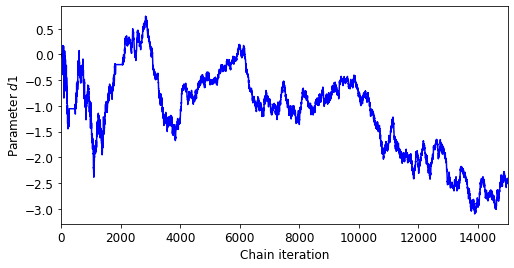

In [8]:
plt.figure(figsize=(8,4))
plt.plot(Q0,'b')
plt.xlim(0,15000)
plt.ylabel('Parameter $d1$',size=12)
plt.xlabel('Chain iteration',size=12)
#plt.ylim(xh1,xh2)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.savefig('Trace_d1.eps')

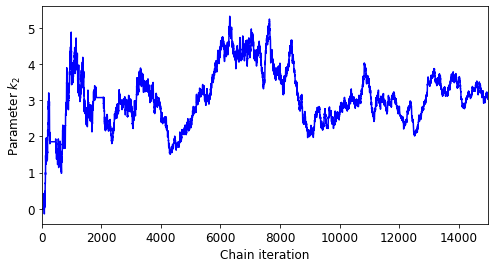

In [9]:
plt.figure(figsize=(8,4))
plt.plot(Q1,'b')
plt.xlim(0,15000)
plt.ylabel('Parameter $k_2$',size=12)
plt.xlabel('Chain iteration',size=12)
#plt.ylim(xh1,xh2)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.savefig('Trace_k2.eps')

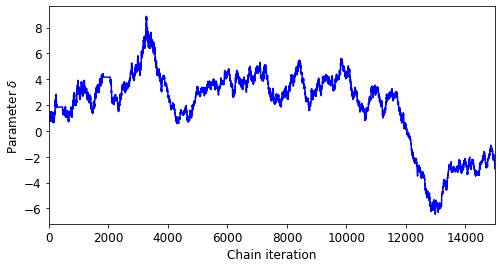

In [10]:
plt.figure(figsize=(8,4))
plt.plot(Q2,'b')
plt.xlim(0,15000)
plt.ylabel('Parameter $\delta$',size=12)
plt.xlabel('Chain iteration',size=12)
#plt.ylim(xh1,xh2)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.savefig('Trace_delta.eps')

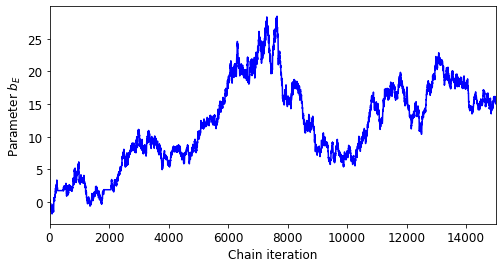

In [11]:
plt.figure(figsize=(8,4))
plt.plot(Q3,'b')
plt.xlim(0,15000)
plt.ylabel('Parameter $b_E$',size=12)
plt.xlabel('Chain iteration',size=12)
#plt.ylim(xh1,xh2)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.savefig('Trace_bE.eps')

## COVARIANCE

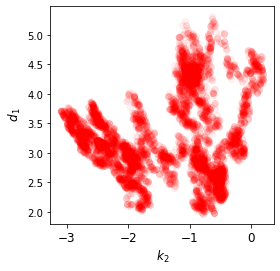

In [29]:
plt.figure(figsize=(4,4))
plt.plot(Q0[5000:],Q1[5000:],'ro',alpha=0.051)
plt.ylabel(' $d_1 $',size=12)
plt.xlabel(' $k_2$',size=12)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('d1_k2.png')

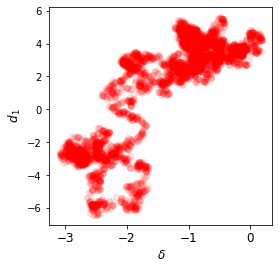

In [30]:
plt.figure(figsize=(4,4))
plt.plot(Q0[5000:],Q2[5000:],'ro',alpha=0.051)
plt.ylabel(' $d_1 $',size=12)
plt.xlabel(' $\delta$',size=12)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('d1_delta.png')

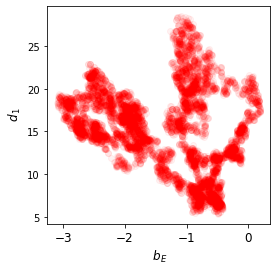

In [31]:
plt.figure(figsize=(4,4))
plt.plot(Q0[5000:],Q3[5000:],'ro',alpha=0.051)
plt.ylabel(' $d_1 $',size=12)
plt.xlabel(' $b_E$',size=12)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('d1_bE.png')

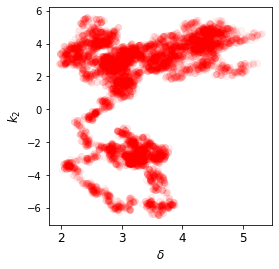

In [32]:
plt.figure(figsize=(4,4))
plt.plot(Q1[5000:],Q2[5000:],'ro',alpha=0.051)
plt.ylabel('$k_2 $',size=12)
plt.xlabel('$\delta$',size=12)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('k2_delta.png')

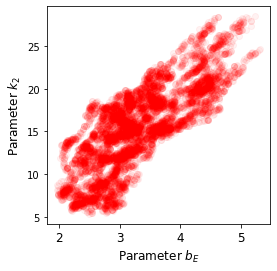

In [33]:
plt.figure(figsize=(4,4))
plt.plot(Q1[5000:],Q3[5000:],'ro',alpha=0.051)
plt.ylabel('Parameter $k_2 $',size=12)
plt.xlabel('Parameter $b_E$',size=12)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('k2_bE.png')

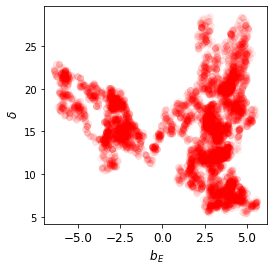

In [35]:
plt.figure(figsize=(4,4))
plt.plot(Q2[5000:],Q3[5000:],'ro',alpha=0.051)
plt.ylabel(' $\delta $',size=12)
plt.xlabel(' $b_E$',size=12)

plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('delta_bE.png')

## KDE

In [37]:
def kde(xd,x_grid):
    kde = stats.kde.gaussian_kde(xd)
    return kde.evaluate(x_grid)

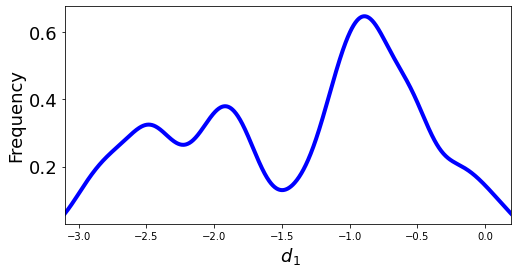

In [44]:
xp1 =min(Q0[5000:]); xp2 = max(Q0[5000:])
xp = np.linspace(xp1,xp2,1000)
#xh1 = 1.8E-3; xh2 = 2.0E-3
#xh = np.linspace(xh1,xh2,1000)
pdfp = kde(Q0[5000:],xp)
#pdfh = kde(Q1,xh)

plt.figure(figsize=(8,4))
plt.plot(xp,pdfp,'b',linewidth=4)
plt.xlim(xp1,xp2)
#plt.ylim(0,3)
plt.ylabel('Frequency',size=18)
plt.xlabel(' $d_1$',size=18)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Margnial_d1.eps')


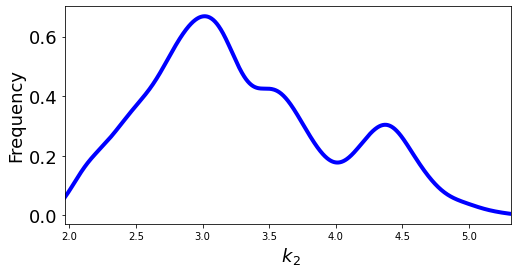

In [45]:
xp1 =min(Q1[5000:]); xp2 = max(Q1[5000:])
xp = np.linspace(xp1,xp2,1000)
#xh1 = 1.8E-3; xh2 = 2.0E-3
#xh = np.linspace(xh1,xh2,1000)
pdfp = kde(Q1[5000:],xp)
#pdfh = kde(Q1,xh)

plt.figure(figsize=(8,4))
plt.plot(xp,pdfp,'b',linewidth=4)
plt.xlim(xp1,xp2)
#plt.ylim(0,3)
plt.ylabel('Frequency',size=18)
plt.xlabel(' $k_2$',size=18)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Margnial_k2.eps')


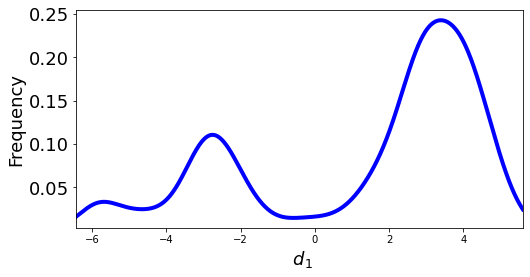

In [46]:
xp1 =min(Q2[5000:]); xp2 = max(Q2[5000:])
xp = np.linspace(xp1,xp2,1000)
#xh1 = 1.8E-3; xh2 = 2.0E-3
#xh = np.linspace(xh1,xh2,1000)
pdfp = kde(Q2[5000:],xp)
#pdfh = kde(Q1,xh)

plt.figure(figsize=(8,4))
plt.plot(xp,pdfp,'b',linewidth=4)
plt.xlim(xp1,xp2)
#plt.ylim(0,3)
plt.ylabel('Frequency',size=18)
plt.xlabel(' $d_1$',size=18)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Margnial_delta.eps')


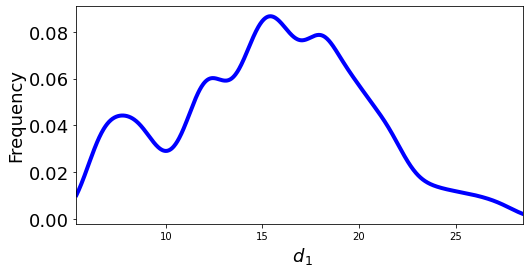

In [47]:
xp1 =min(Q3[5000:]); xp2 = max(Q3[5000:])
xp = np.linspace(xp1,xp2,1000)
#xh1 = 1.8E-3; xh2 = 2.0E-3
#xh = np.linspace(xh1,xh2,1000)
pdfp = kde(Q3[5000:],xp)
#pdfh = kde(Q1,xh)

plt.figure(figsize=(8,4))
plt.plot(xp,pdfp,'b',linewidth=4)
plt.xlim(xp1,xp2)
#plt.ylim(0,3)
plt.ylabel('Frequency',size=18)
plt.xlabel(' $d_1$',size=18)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Margnial_bE.eps')
